In [133]:
# imports
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [72]:
# datafiles
os.getcwd()
os.path.exists("..\\files\\")
# emotion.csv is a one-hot encoding table that tells what emotion is conveyed in each wave file
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
emotion = pd.read_csv("..\\files\\emotion.csv")
emotion = pd.DataFrame(
            {'file_name': emotion['file_name'], 
             'neutral': emotion['1'],
             'calm':emotion['2'],
             'happy':emotion['3'],
             'sad':emotion['4'],
             'angry':emotion['5'],
             'fearful': emotion['6'],
             'disgust':emotion['7'],
             'surprised': emotion['8']
            })
# ravdess_audio_file_attributes.csv has all the attributes for each audio file including modality, voice_channel, emotion, intensity, statement, Repetition, actor, gender of actor
audiofile_attributes = pd.read_csv("..\\files\\ravdess_audio_file_attributes.csv")
# not sure why I made this but i feel it may come in handy
audiofile_emotion = pd.DataFrame({'file': audiofile_attributes['file_name'], 'emotion':audiofile_attributes['Emotion']})

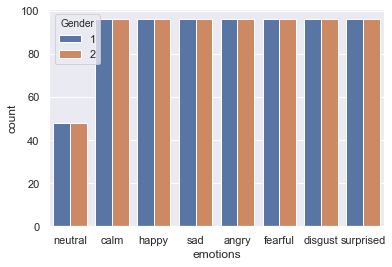

In [81]:
# Beginning of some quick visualizations
# All of my attributes are categorical, so I will just show boxplots
# These are plots for the entire dataset will be doing test train sets here soon 
sns.set(style="darkgrid")
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

emotionList = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
for i in range(1,9):
    audiofile_attributes.loc[audiofile_attributes['Emotion'] == i, 'emotions'] = emotionList[i-1]


emotionCountByGender = sns.countplot(x=audiofile_attributes['emotions'], hue = audiofile_attributes['Gender'])
# Why the count for neutral is half: Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

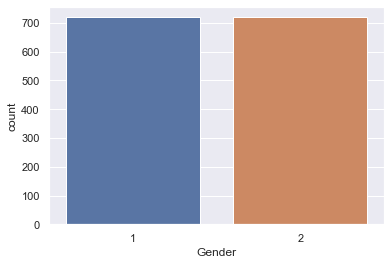

In [82]:
genderCount = sns.countplot(x=audiofile_attributes['Gender'])

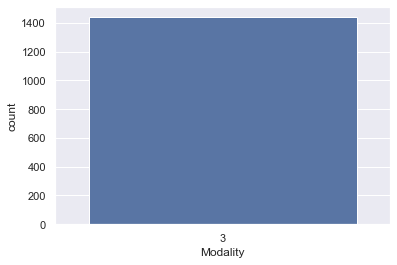

In [84]:
# Show that all are the same modality
# Modality (01 = full-AV, 02 = video-only, 03 = audio-only)
modalityCount = sns.countplot(x=audiofile_attributes['Modality'])
# All are audio-only files

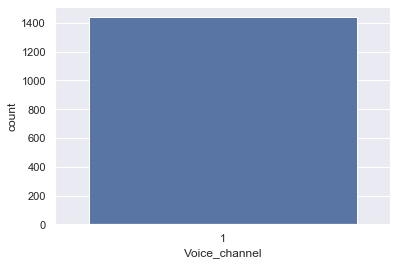

In [89]:
# Show that all are the same Vocal channel 
# Vocal channel (01 = speech, 02 = song)
VocalChannelCount = sns.countplot(x=audiofile_attributes['Voice_channel'])
# All are speech audio files

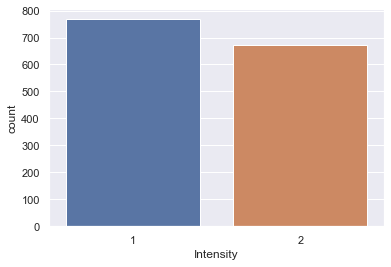

In [86]:
# Show the counts for intensity 
# Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

intensityCount = sns.countplot(x=audiofile_attributes['Intensity'])
# There are more normal intensity than strong, because neutral does not have a strong intensity

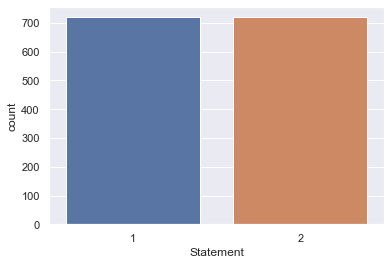

In [88]:
# Show the counts for Statements 
# Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

statementCount = sns.countplot(x=audiofile_attributes['Statement'])
# Each statement is said the same number of times

In [152]:
# now to split into training and testing sets
# There are 1440 files, so maybe an 80-20 split

,Modality,Voice_channel,Emotion,Intensity,Statement,Repetition,Actor,Gender
count,1152.0,1152.0,1152.000000,1152.000000,1152.000000,1152.000000,1152.00000,1152.000000
mean,3.0,1.0,4.753472,1.473090,1.490451,1.515625,12.44184,1.513021
std,0.0,0.0,2.176405,0.499492,0.500126,0.499973,6.89830,0.500048
min,3.0,1.0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
25%,3.0,1.0,3.000000,1.000000,1.000000,1.000000,6.75000,1.000000
50%,3.0,1.0,5.000000,1.000000,1.000000,2.000000,12.00000,2.000000
75%,3.0,1.0,7.000000,2.000000,2.000000,2.000000,18.00000,2.000000
max,3.0,1.0,8.000000,2.000000,2.000000,2.000000,24.00000,2.000000


In [153]:
y = audiofile_attributes['Emotion']
X_train, X_test, y_train, y_test = train_test_split(audiofile_attributes, y, test_size=0.2)

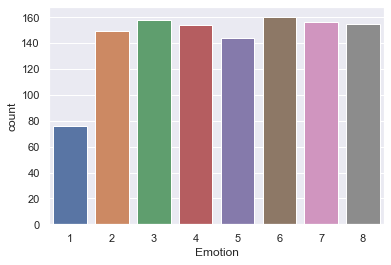

In [141]:
sns.countplot(x=X_train['Emotion'])

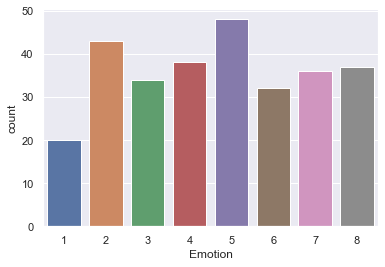

In [142]:
sns.countplot(x=X_test['Emotion'])

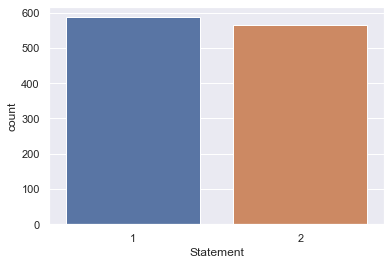

In [143]:
sns.countplot(x=X_train['Statement'])

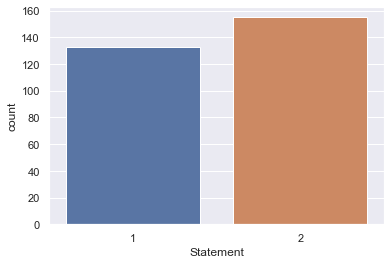

In [144]:
sns.countplot(x=X_test['Statement'])

In [ ]:
## before construction of Model
# Converting audio data into mel-spectogram


In [155]:
X_train

,file_name,Modality,Voice_channel,Emotion,Intensity,Statement,Repetition,Actor,Gender,emotions
702,03-01-05-01-01-02-07.wav,3,1,5,1,1,2,7,1,angry
630,03-01-04-02-02-01-07.wav,3,1,4,2,2,1,7,1,sad
666,03-01-04-02-02-02-19.wav,3,1,4,2,2,2,19,1,sad
1191,03-01-07-02-01-02-16.wav,3,1,7,2,1,2,16,2,disgust
1225,03-01-07-02-02-02-02.wav,3,1,7,2,2,2,2,2,disgust
...,...,...,...,...,...,...,...,...,...,...
811,03-01-05-02-01-02-20.wav,3,1,5,2,1,2,20,2,angry
132,03-01-02-01-01-02-13.wav,3,1,2,1,1,2,13,1,calm
914,03-01-06-01-02-01-03.wav,3,1,6,1,2,1,3,1,fearful
1271,03-01-08-01-01-01-24.wav,3,1,8,1,1,1,24,2,surprised


..\ravdess-emotional-speech-audio\03-01-08-01-01-01-24.wav
72839 22050


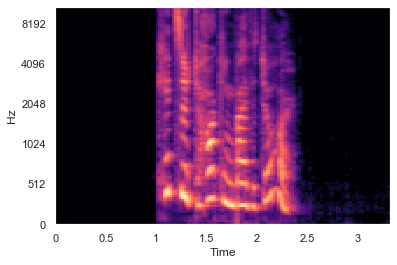

In [157]:
# Try some things out first
filename = "..\\ravdess-emotional-speech-audio\\" + X_train['file_name'][1271]
print(filename)
y, sr = librosa.load(filename)
print(len(y),sr)
spect = librosa.feature.melspectrogram(y=y, sr=sr)
spect = librosa.power_to_db(spect, ref=np.max)
librosa.display.specshow(spect, y_axis='mel', x_axis='time')
